- Environment Setup

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [3]:
import wrangle

from wrangle import wrangle_sa_temp

# Data Wrangling

In [4]:
df = wrangle_sa_temp()

In [5]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1823-01-01,9.425,2.788,1,1823
1823-02-01,9.864,3.157,2,1823
1823-03-01,16.228,2.660,3,1823
1823-04-01,20.097,3.091,4,1823
1823-05-01,23.811,2.044,5,1823


In [6]:
df.shape

(2289, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2289 entries, 1823-01-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2289 non-null   float64
 1   AverageTemperatureUncertainty  2289 non-null   float64
 2   month                          2289 non-null   int64  
 3   year                           2289 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 89.4 KB


In [8]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,year
count,2289.000000,2289.000000,2289.000000,2289.000000
mean,19.970752,0.795954,6.494102,1917.875491
std,6.872652,0.798271,3.451093,55.076907
min,4.023000,0.061000,1.000000,1823.000000
25%,13.737000,0.261000,3.000000,1870.000000
50%,20.292000,0.391000,6.000000,1918.000000
75%,26.686000,1.193000,9.000000,1966.000000
max,32.166000,5.063000,12.000000,2013.000000


In [9]:
df.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
month                            0
year                             0
dtype: int64

# Data Splitting

In [10]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

## Verify Splits

In [11]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [12]:
print(df.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty  month  year
dt                                                                        
1823-01-01                True                           True   True  True


In [13]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1975-06-01,26.924,0.196,6,1975
1975-07-01,27.702,0.328,7,1975


In [14]:
pd.concat([test.tail(1), df.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
2013-09-01,27.727,1.123,9,2013
2013-09-01,27.727,1.123,9,2013


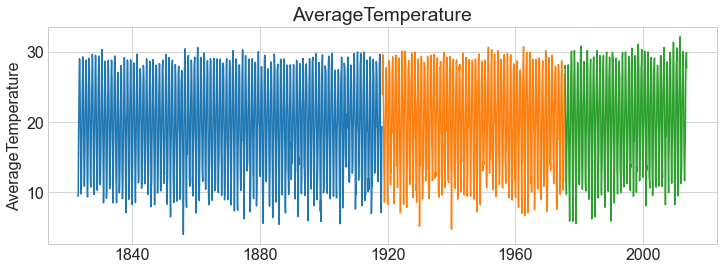

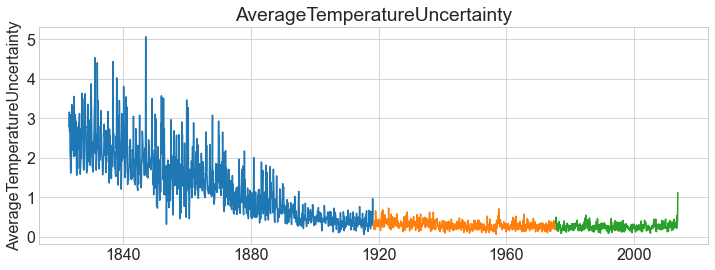

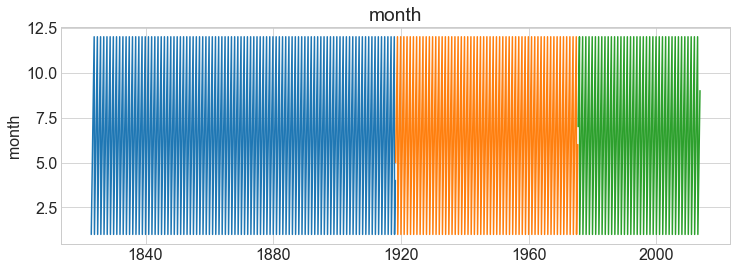

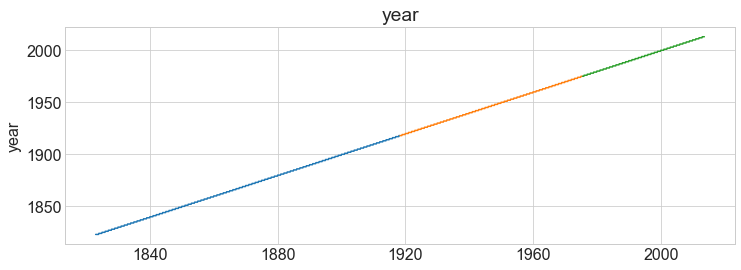

In [15]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Helper Evaluate Functions

In [16]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 5)
    return rmse

In [17]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [18]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [19]:
eval_df

,model_type,target_var,rmse


# Modeling

## Last observed value

### Make Predictions

In [20]:
temp = train['AverageTemperature'][-1:][0]


yhat_df = pd.DataFrame({'AverageTemperature': [temp]}, 
                       index = validate.index)

yhat_df.head(2)

,AverageTemperature
dt,
1918-05-01,19.381
1918-06-01,19.381


### Plot Actual vs. Predicted Values

AverageTemperature -- RMSE: 7


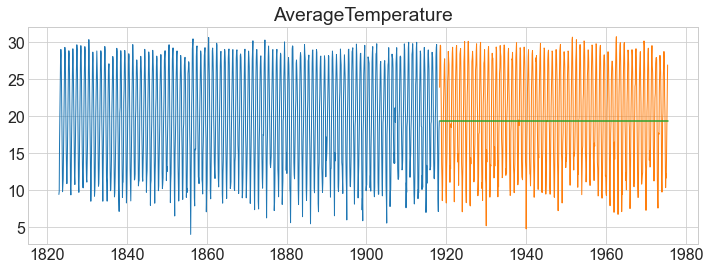

In [21]:
plot_and_eval('AverageTemperature')

In [22]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'AverageTemperature')

In [23]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,6.89876


## Simple Average

### Make Predictions

In [24]:
# compute simple average
temp = round(train['AverageTemperature'].mean(),2)
temp

19.67

In [25]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [temp]}, 
                           index = validate.index)
    return yhat_df

In [26]:
yhat_df = make_predictions()

In [27]:
yhat_df.head(2)

,AverageTemperature
dt,
1918-05-01,19.67
1918-06-01,19.67


### Plot Actual vs. Predicted Values

AverageTemperature -- RMSE: 7


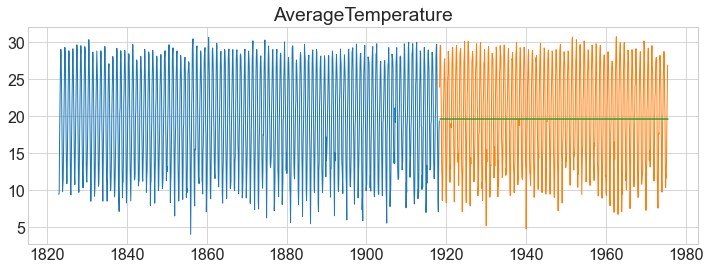

In [28]:
plot_and_eval('AverageTemperature')

### Evaluate

In [29]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'AverageTemperature')

In [30]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,6.89876
1,simple_average,AverageTemperature,6.87271


## Moving Average

In [31]:
period = 30 

# take 30 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)


print(temp)

19.05


In [32]:
yhat_df = make_predictions()
yhat_df.head()

,AverageTemperature
dt,
1918-05-01,19.05
1918-06-01,19.05
1918-07-01,19.05
1918-08-01,19.05
1918-09-01,19.05


AverageTemperature -- RMSE: 7


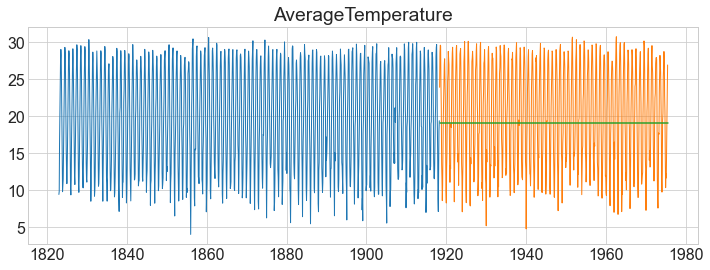

In [33]:
plot_and_eval('AverageTemperature')

### Evaluate

In [34]:
eval_df = append_eval_df(model_type = '30m_moving_avg', 
                            target_var = 'AverageTemperature')

In [35]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,6.89876
1,simple_average,AverageTemperature,6.87271
2,30m_moving_avg,AverageTemperature,6.94327


In [36]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    temp = round(train['AverageTemperature'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature'
                            )

In [37]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,6.89876
1,simple_average,AverageTemperature,6.87271
2,30m_moving_avg,AverageTemperature,6.94327
3,1m moving average,AverageTemperature,6.89887
4,4m moving average,AverageTemperature,9.02979
5,12m moving average,AverageTemperature,6.88121
6,26m moving average,AverageTemperature,6.86348
7,52m moving average,AverageTemperature,6.89454
8,104m moving average,AverageTemperature,6.88294


In [38]:
min_temp_rmse = eval_df[eval_df.target_var == 'AverageTemperature']['rmse'].min()

eval_df[eval_df.rmse == min_temp_rmse]

,model_type,target_var,rmse
6,26m moving average,AverageTemperature,6.86348


## Holt's Linear Trend

### Seasonal Decomposition

AverageTemperature 



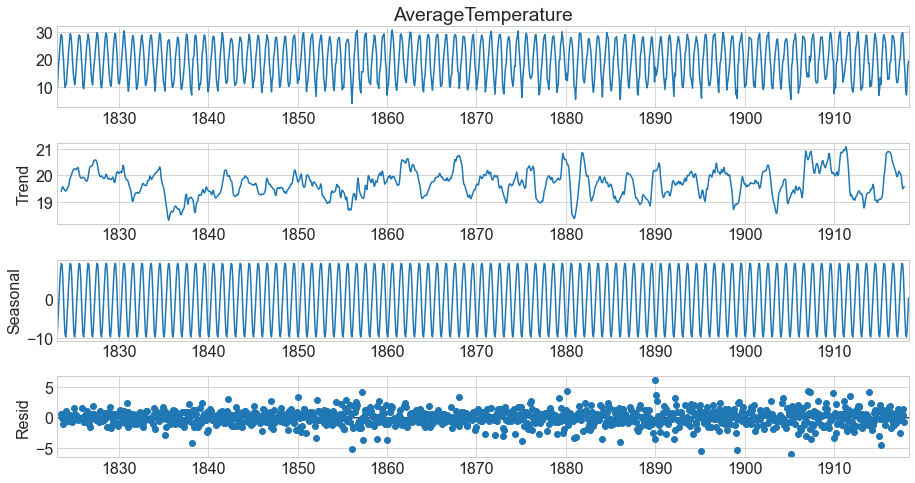

AverageTemperatureUncertainty 



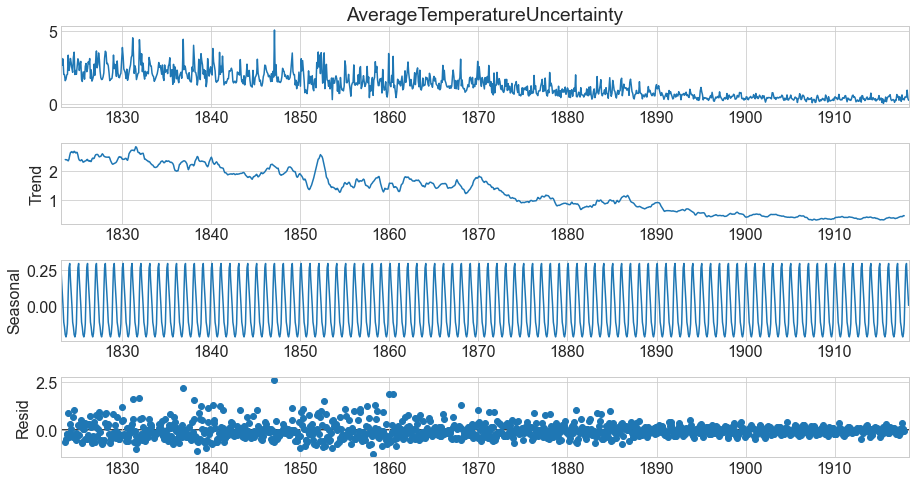

month 



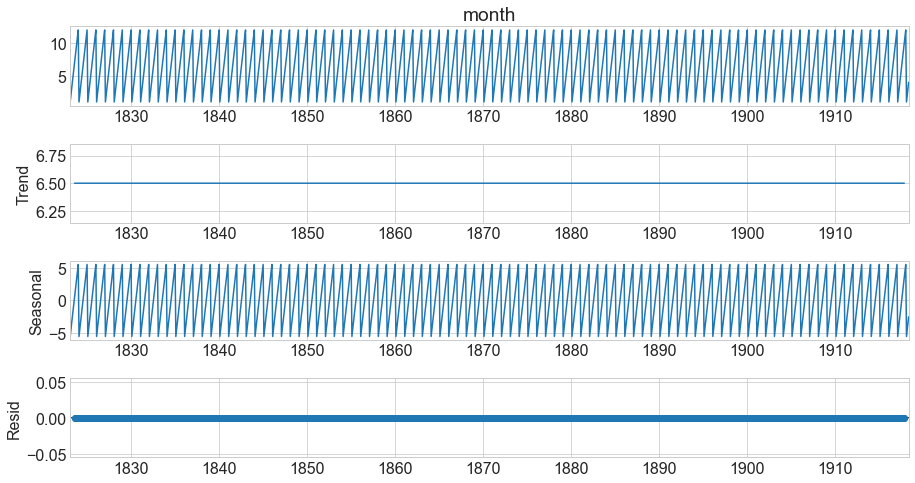

year 



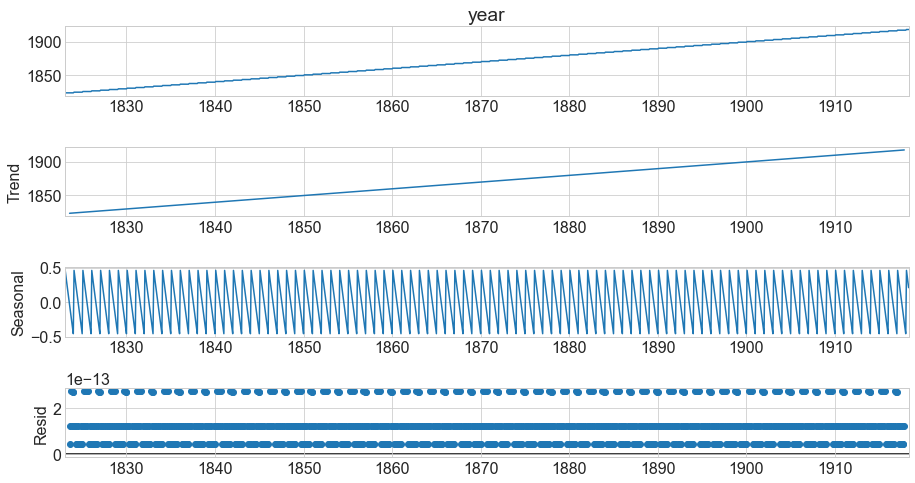

In [39]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

### Make Predictions

In [40]:
model = Holt(train['AverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .01, 
                      smoothing_slope = .01, 
                      optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
yhat_df['AverageTemperature'] = round(yhat_items, 2)

AverageTemperature -- RMSE: 7


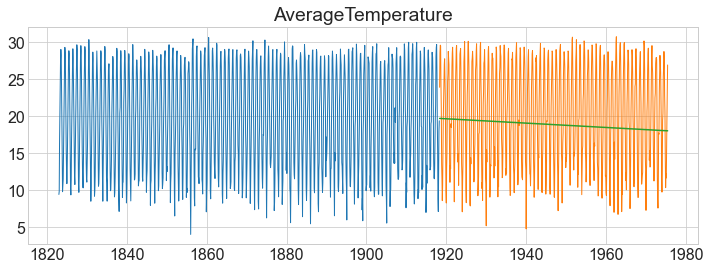

In [41]:
plot_and_eval(target_var = 'AverageTemperature')

### Evaluate

In [42]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = 'AverageTemperature')

In [43]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,6.89876
1,simple_average,AverageTemperature,6.87271
2,30m_moving_avg,AverageTemperature,6.94327
3,1m moving average,AverageTemperature,6.89887
4,4m moving average,AverageTemperature,9.02979
5,12m moving average,AverageTemperature,6.88121
6,26m moving average,AverageTemperature,6.86348
7,52m moving average,AverageTemperature,6.89454
8,104m moving average,AverageTemperature,6.88294
9,Holts,AverageTemperature,6.98753


## Predict Based on Previous Cycle

In [44]:
test.tail()

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
2013-05-01,23.617,0.217,5,2013
2013-06-01,28.652,0.537,6,2013
2013-07-01,28.946,0.329,7,2013
2013-08-01,29.937,0.416,8,2013
2013-09-01,27.727,1.123,9,2013


### Re-split data

In [45]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

### Make Predictions

In [46]:
yhat_df = train['2010'] + train.diff(12).mean()

In [47]:
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
2010-01-01,9.210037,0.217431,1.0,2011.0
2011-01-01,9.547000,0.297000,1.0,2011.0


In [48]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

12

### Plot and Evaluate

AverageTemperature -- RMSE: 2


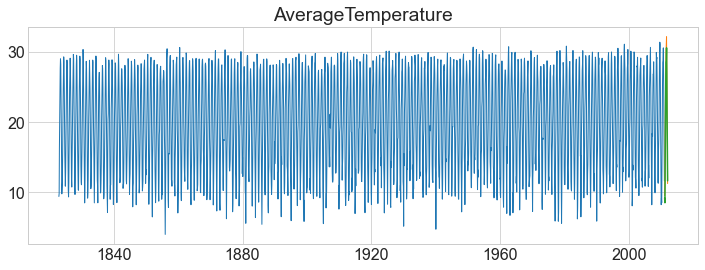

In [49]:
plot_and_eval(target_var = 'AverageTemperature')

eval_df = append_eval_df(model_type = 'previous year', target_var = 'AverageTemperature')

# Conclusion

In [50]:
min_temp_rmse = eval_df[eval_df.target_var == 'AverageTemperature']['rmse'].min()

eval_df[eval_df.rmse == min_temp_rmse]

,model_type,target_var,rmse
10,previous year,AverageTemperature,2.11015


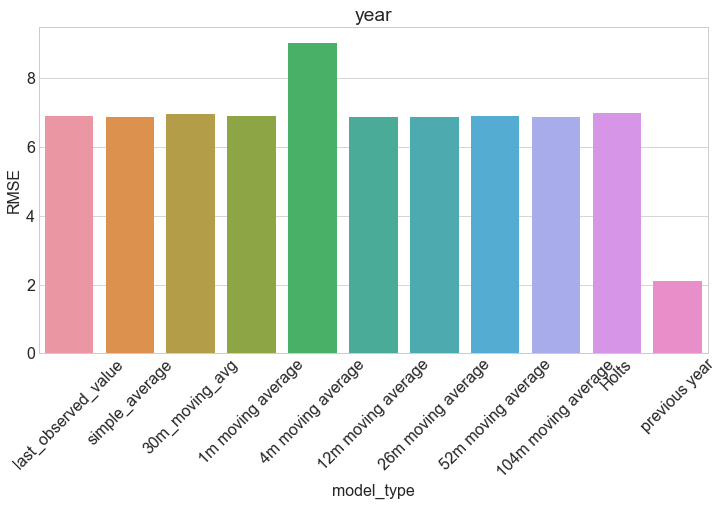

In [51]:
x = eval_df[eval_df.target_var == 'AverageTemperature']['model_type']
y = eval_df[eval_df.target_var == 'AverageTemperature']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

In [52]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [54]:
rmse_temp = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature'])), 5)

print("rmse - AverageTemperature: ", rmse_temp)

rmse - AverageTemperature:  1.57642


AverageTemperature -- RMSE: 0


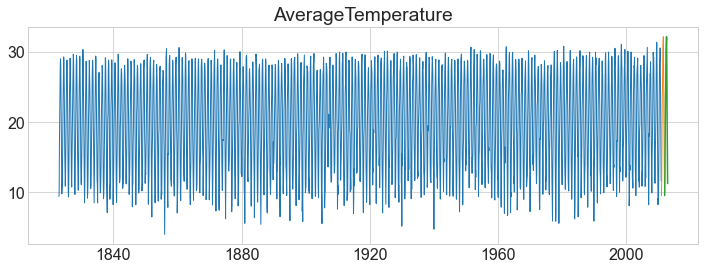

In [55]:
plot_and_eval('AverageTemperature')